In [1]:
import pandas as pd
import numpy as np
from os import listdir

#Pour le LSTM 
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.preprocessing import MinMaxScaler
from keras.layers import Input, LSTM, Dense, TimeDistributed, Activation, BatchNormalization, Dropout, Bidirectional
from keras.models import Sequential
from keras.utils import Sequence
from keras.layers import CuDNNLSTM

2022-12-02 10:13:55.917515: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-12-02 10:13:57.569392: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-02 10:13:57.569533: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-02 10:13:57.569545: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [ ]:
# onlyfiles = [f for f in listdir("../raw_data/crypto_data")]
# onlyfiles

In [2]:
npz = np.load("../raw_data/BTC-USDT.npz")
df1 = pd.DataFrame(npz["arr_0"])
df2 = pd.DataFrame(npz["arr_1"])

df = pd.concat([df1,df2],axis=1)
df.columns = ["open_time","close"]

In [ ]:
# df = pd.read_csv('../raw_data/btcusd.csv')

# df['time'] = pd.to_datetime(df.loc[:,'time'], unit="ms")
# df.head()
# df.dtypes

In [ ]:
# start = df['open_time']>= '2019-01-01 00:00:00'
# df_filtered = df.loc[start]

# df_filtered.head()

In [3]:
%matplotlib inline

sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 14, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

Text(0, 0.5, 'Close Price (USD)')

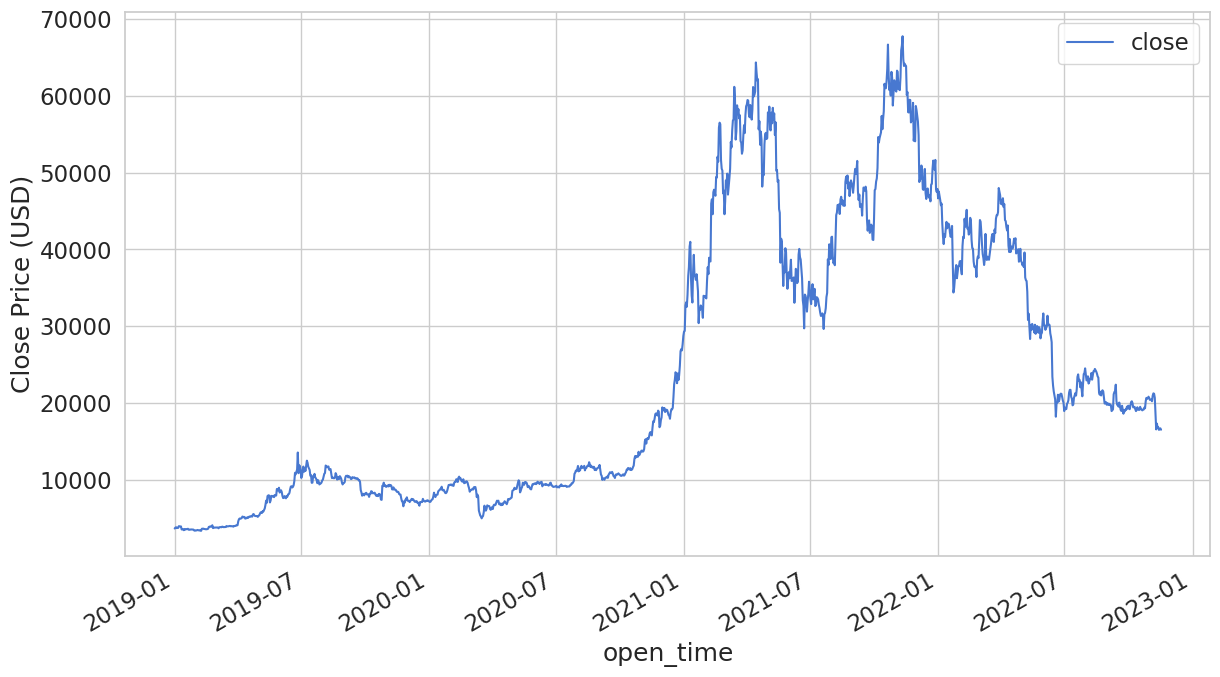

In [4]:
ax = df.plot(x='open_time', y='close');
ax.set_xlabel("open_time")
ax.set_ylabel("Close Price (USD)")

In [ ]:
# ax = df_filtered.plot(x='open_time', y='close');
# ax.set_xlabel("open_time")
# ax.set_ylabel("Close Price (USD)")

In [5]:
scaler = MinMaxScaler()

close_price = df.close.values.reshape(-1, 1)

scaled_close = scaler.fit_transform(close_price)

In [ ]:
# scaler = MinMaxScaler()

# close_price = df_filtered.close.values.reshape(-1, 1)

# scaled_close = scaler.fit_transform(close_price)

In [6]:
scaled_close.shape

(1414, 1)

In [7]:
np.isnan(scaled_close).any()

False

In [8]:
scaled_close = scaled_close[~np.isnan(scaled_close)]

In [9]:
scaled_close = scaled_close.reshape(-1, 1)

In [10]:
np.isnan(scaled_close).any()

False

In [ ]:
SEQ_LEN = 100

def to_sequences(data, seq_len):
    d = []

    for index in range(len(data) - seq_len):
        d.append(data[index: index + seq_len])

    return np.array(d)

def preprocess(data_raw, seq_len, train_split):

    data = to_sequences(data_raw, seq_len)

    num_train = int(train_split * data.shape[0])

    X_train = data[:num_train, :-1, :]
    y_train = data[:num_train, -1, :]

    X_test = data[num_train:, :-1, :]
    y_test = data[num_train:, -1, :]

    return X_train, y_train, X_test, y_test


X_train, y_train, X_test, y_test = preprocess(scaled_close, SEQ_LEN, train_split = 0.95)

In [ ]:
X_train.shape

In [ ]:
X_test.shape

In [ ]:
DROPOUT = 0.2
WINDOW_SIZE = SEQ_LEN - 1

model = Sequential()

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=True),
                        input_shape=(WINDOW_SIZE, X_train.shape[-1])))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM((WINDOW_SIZE * 2), return_sequences=True)))
model.add(Dropout(rate=DROPOUT))

model.add(Bidirectional(CuDNNLSTM(WINDOW_SIZE, return_sequences=False)))

model.add(Dense(units=1))

model.add(Activation('linear'))

In [ ]:
model.compile(
    loss='mean_squared_error', 
    optimizer='adam'
)

In [ ]:
BATCH_SIZE = 64

history = model.fit(
    X_train, 
    y_train, 
    epochs=5, 
    batch_size=BATCH_SIZE, 
    shuffle=False,
    validation_split=0.1
)

In [ ]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf

check_gpu = len(tf.config.list_physical_devices('GPU'))>0

print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
print("GPU is", "available" if check_gpu \
      else "NOT AVAILABLE")

In [ ]:
!pip freeze | grep tensorflow